# # Coronavirus 2020 - effectiveness of measures taken - Spain

In [1]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
# Alternative plotting backend for interative data exploration
# %matplotlib notebook

from coronavirus import *
# If you want to edit the source in the notebook, try "%load coronavirus.py" 
# and comment out the import statement above.

In [2]:
fetch_data_spain()

Please be patient - downloading data from https://covid19.isciii.es/resources/serie_historica_acumulados.csv ...
Completed downloading 1444 rows in 0.4 seconds.


,Admin. region code,Cases,Positive PCR test,Positive Antibody test,Hospitalized,ICU,Deceases,Recovered,New cases
date,,,,,,,,,
2020-02-20,AN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2020-02-20,AR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2020-02-20,AS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2020-02-20,IB,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2020-02-20,CN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...
2020-05-04,ML,0.0,119.0,12.0,44.0,3.0,2.0,101.0,131
2020-05-04,MC,0.0,1496.0,555.0,650.0,111.0,136.0,1381.0,2051
2020-05-04,NC,0.0,4936.0,1625.0,1995.0,134.0,471.0,2562.0,6561


In [3]:
spain = get_ES_region_list()
spain

Please be patient - downloading data from https://covid19.isciii.es/resources/serie_historica_acumulados.csv ...
Completed downloading 1444 rows in 0.7 seconds.


['Andalucía',
 'Aragón',
 'Asturias',
 'Canarias',
 'Cantabria',
 'Castilla y León',
 'Castilla-La Mancha',
 'Cataluña',
 'Ceuta',
 'Com. Madrid',
 'Com. Valenciana',
 'Extremadura',
 'Galicia',
 'Islas Baleares',
 'La Rioja',
 'Melilla',
 'Murcia',
 'Navarra',
 'País Vasco']

Please be patient - downloading data from https://covid19.isciii.es/resources/serie_historica_acumulados.csv ...
Completed downloading 1444 rows in 0.4 seconds.
Please be patient - downloading data from https://covid19.isciii.es/resources/serie_historica_acumulados.csv ...
Completed downloading 1444 rows in 0.4 seconds.
Please be patient - downloading data from https://covid19.isciii.es/resources/serie_historica_acumulados.csv ...
Completed downloading 1444 rows in 0.4 seconds.
Please be patient - downloading data from https://covid19.isciii.es/resources/serie_historica_acumulados.csv ...
Completed downloading 1444 rows in 0.4 seconds.
Please be patient - downloading data from https://covid19.isciii.es/resources/serie_historica_acumulados.csv ...
Completed downloading 1444 rows in 0.6 seconds.
Please be patient - downloading data from https://covid19.isciii.es/resources/serie_historica_acumulados.csv ...
Completed downloading 1444 rows in 0.4 seconds.
Please be patient - downloading da

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


Completed downloading 1444 rows in 0.4 seconds.


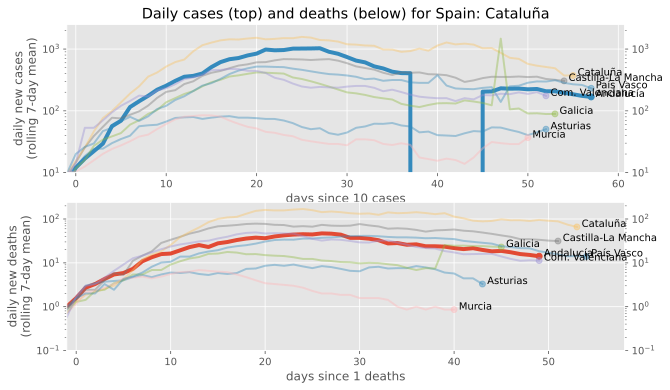

In [4]:
axes, c, d = make_compare_plot_spain("Cataluña")

# Andalucía

In [ ]:
cases_and, deaths_and = spain_get_region("Andalucía")

# La Rioja

In [ ]:
cases_rio, deaths_rio = spain_get_region(region="La Rioja")

# Comunidad de Madrid

In [ ]:
cases, deaths = spain_get_region(region="Com. Madrid")

# Cataluña

In [ ]:
cases, deaths = spain_get_region(region="Cataluña")

# País Vasco

In [ ]:
cases, deaths = spain_get_region(region="País Vasco")

# Canarias

In [ ]:
cases, deaths = spain_get_region(region="Canarias")